<a href="https://colab.research.google.com/github/Yurich3112/UI_Representation_PesPython/blob/main/ScreenShot_representation_PesPython.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Починаємо з перевірики повноти дерева покриття

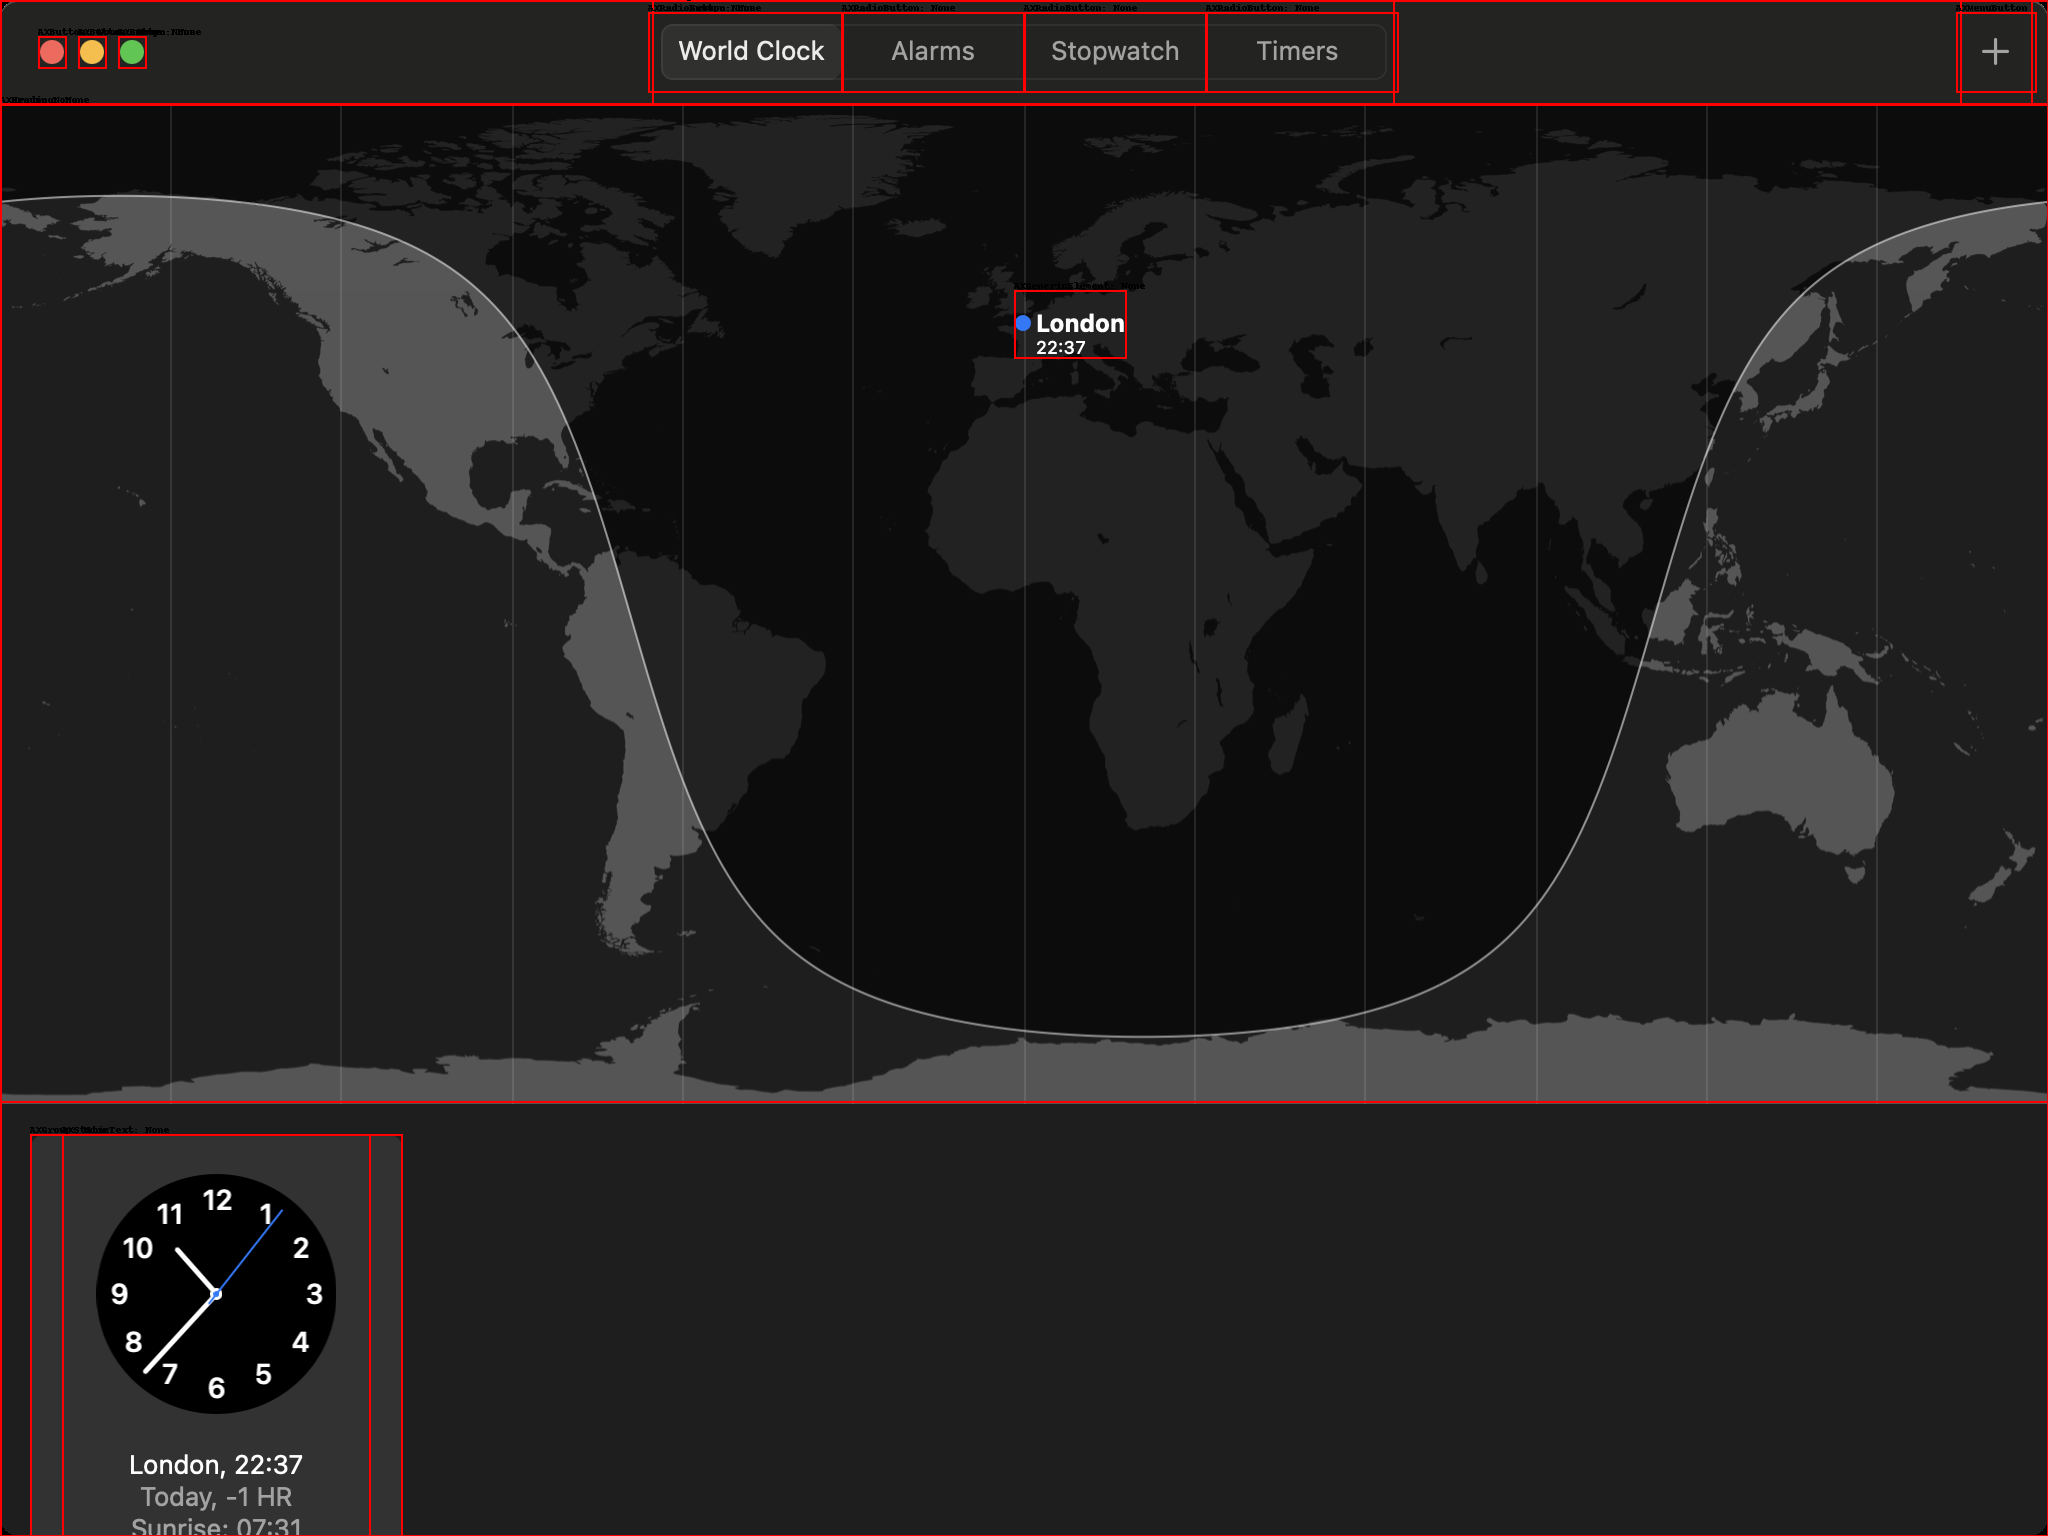

In [ ]:
from PIL import Image, ImageDraw, ImageFont

# Function to draw rectangles around UI elements and annotate them
def draw_and_annotate_elements(node, image_draw, font):
    # Check if the element has a visible bounding box
    if 'visible_bbox' in node and node['visible_bbox']:
        x, y, w, h = node['visible_bbox']
        image_draw.rectangle([(x, y), (x + w, y + h)], outline="red", width=2)

        # Annotate the rectangle with the role or name of the element
        text = node.get('role', 'Unknown')
        if 'name' in node and node['name']:
            text += f": {node['name']}"
        image_draw.text((x, y - 10), text, fill="black", font=font)

    # Recursively process all children
    if 'children' in node:
        for child in node['children']:
            draw_and_annotate_elements(child, image_draw, font)

# Load the screenshot for drawing
screenshot_path = '/content/drive/MyDrive/IASA_Champ_Final/IASA_Champ_Final/app_data/Clock/1707172625/Clock-1707172626.31.png'
screenshot = Image.open(screenshot_path).convert("RGB")
draw = ImageDraw.Draw(screenshot)

# Load a font
font = ImageFont.load_default()

# Draw rectangles and annotate UI elements using the loaded JSON data
draw_and_annotate_elements(json_Adata, draw, font)

# Save the edited image with rectangles and annotations
annotated_screenshot_path = '/content/drive/MyDrive/IASA_Champ_Final/IASA_Champ_Final/app_data/Clock/1707172625/annotated_screenshot.png'
screenshot.save(annotated_screenshot_path)

from IPython.display import Image as ColabImage

# Function to display the annotated image
def show_annotated_image(image_path):
    display(ColabImage(image_path))

# Call the function to display the image
show_annotated_image(annotated_screenshot_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Генеруємо текстову репрезентацію на основі json файлу

In [ ]:
# Check for a direct app name key
app_name_key = 'name'  # This is an assumption, the actual key might be different
app_name = json_data.get(app_name_key, "Unknown App") if isinstance(json_data, dict) else "Unknown App"

app_name


def create_readable_text_representation(node, descriptions, depth=0, parent_name='', app_name="Unknown App"):
    name = node.get('name', parent_name)
    role = node.get('role', 'element').replace('AX', '')  # Remove 'AX' prefix for readability
    position = node.get('visible_bbox', 'at an unknown position')
    state = node.get('value', None)

    # Create a more natural language description
    if role == 'CheckBox':
        state_description = 'checked' if state == 1 else 'unchecked'
    elif role == 'StaticText':
        state_description = f"containing the text '{state}'" if state else 'empty'
    else:
        state_description = f"with the state '{state}'" if state else ''

    # Adding app name to the description
    description = f"In the {app_name} app, there is a {role.lower()} named '{name}' {state_description}, located at {position}."
    descriptions.append(description.capitalize())

    # If the element has children, process them as well
    if 'children' in node:
        for child in node['children']:
            create_readable_text_representation(child, descriptions, depth + 1, name, app_name)

# Starting with an empty list
readable_descriptions = []
create_readable_text_representation(json_data, readable_descriptions, app_name=app_name)

# Join the descriptions into a single string
readable_text_representation = '\n'.join(readable_descriptions)
print(readable_text_representation)


In the clock app, there is a window named 'clock' with the state 'none', located at [0, 0, 2048, 1536].
In the clock app, there is a group named 'none' with the state 'none', located at [0, 0, 2048, 1536].
In the clock app, there is a group named 'none' with the state 'none', located at [0, 0, 2048, 1536].
In the clock app, there is a group named 'none' with the state 'none', located at [0, 0, 2048, 1536].
In the clock app, there is a group named 'none' with the state 'none', located at [0, 0, 2048, 1536].
In the clock app, there is a group named 'none' with the state 'none', located at [0, 104, 2048, 1432].
In the clock app, there is a heading named 'none' with the state 'none', located at [0, 104, 2048, 998].
In the clock app, there is a genericelement named 'none' with the state 'none', located at [1014, 290, 112, 68].
In the clock app, there is a group named 'none' with the state 'none', located at [30, 1134, 372, 402].
In the clock app, there is a statictext named 'none' containin

Все що вище -- ми брали вже готовий json і читали дані з нього. Тут будемо використовувати YOLO v5 аби самим розпізнавати всю структуру

In [ ]:
import torch
import numpy as np
from PIL import Image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# --- Constants ---
image_size = (224, 224)

# --- Load UI Class Map from JSON ---
# --- Load UI Class Map (Updated with the Correct Path) ---
with open('/content/drive/MyDrive/IASA_Champ_Final/ui_class_map.json', 'r') as f:
    UI_CLASS_MAP = json.load(f)



# --- Model Loading ---
# YOLOv5
yolo_model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5s.pt')

# MobileNetV2 (load from TensorFlow "tf" format)
mobilenet_model = load_model('/content/drive/MyDrive/IASA_Champ_Final/mobik_net')

# ---  Detection and Classification Function ---
def detect_and_classify_ui_elements(image_path):
    img = Image.open(image_path).convert('RGB')
    img = np.array(img)

    results = yolo_model(img)
    detections = results.pandas().xyxy[0]

    for index, row in detections.iterrows():
        x1, y1, x2, y2 = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])

        crop_img = img[y1:y2, x1:x2]
        crop_img = Image.fromarray(crop_img)
        crop_img = crop_img.resize(image_size)
        crop_img = preprocess_input(np.array(crop_img).astype('float32'))
        crop_img = np.expand_dims(crop_img, axis=0)

        predictions = mobilenet_model.predict(crop_img)
        predicted_class_index = np.argmax(predictions, axis=1)[0]

        # Obtain the actual class label
        class_label = UI_CLASS_MAP.get(predicted_class_index, 'Unknown')

        print(f"Detected {class_label} at [{x1}, {y1}, {x2}, {y2}]")

# ---  Execution ---
detect_and_classify_ui_elements('/content/drive/MyDrive/IASA_Champ_Final/IASA_Champ_Final/app_data/Clock/1707172625/Clock-1707172626.31.png')


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-2-10 Python-3.10.12 torch-2.1.0+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


1/1 [==============================] - 1s 686ms/step
Detected Unknown at [94, 1173, 339, 1417]
1/1 [==============================] - 0s 57ms/step
Detected Unknown at [1050, 190, 1262, 358]
1/1 [==============================] - 0s 61ms/step
Detected Unknown at [13, 182, 614, 580]


Те саме тільки з виводом зображення і боксів поверх

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-2-10 Python-3.10.12 torch-2.1.0+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


1/1 [==============================] - 0s 112ms/step


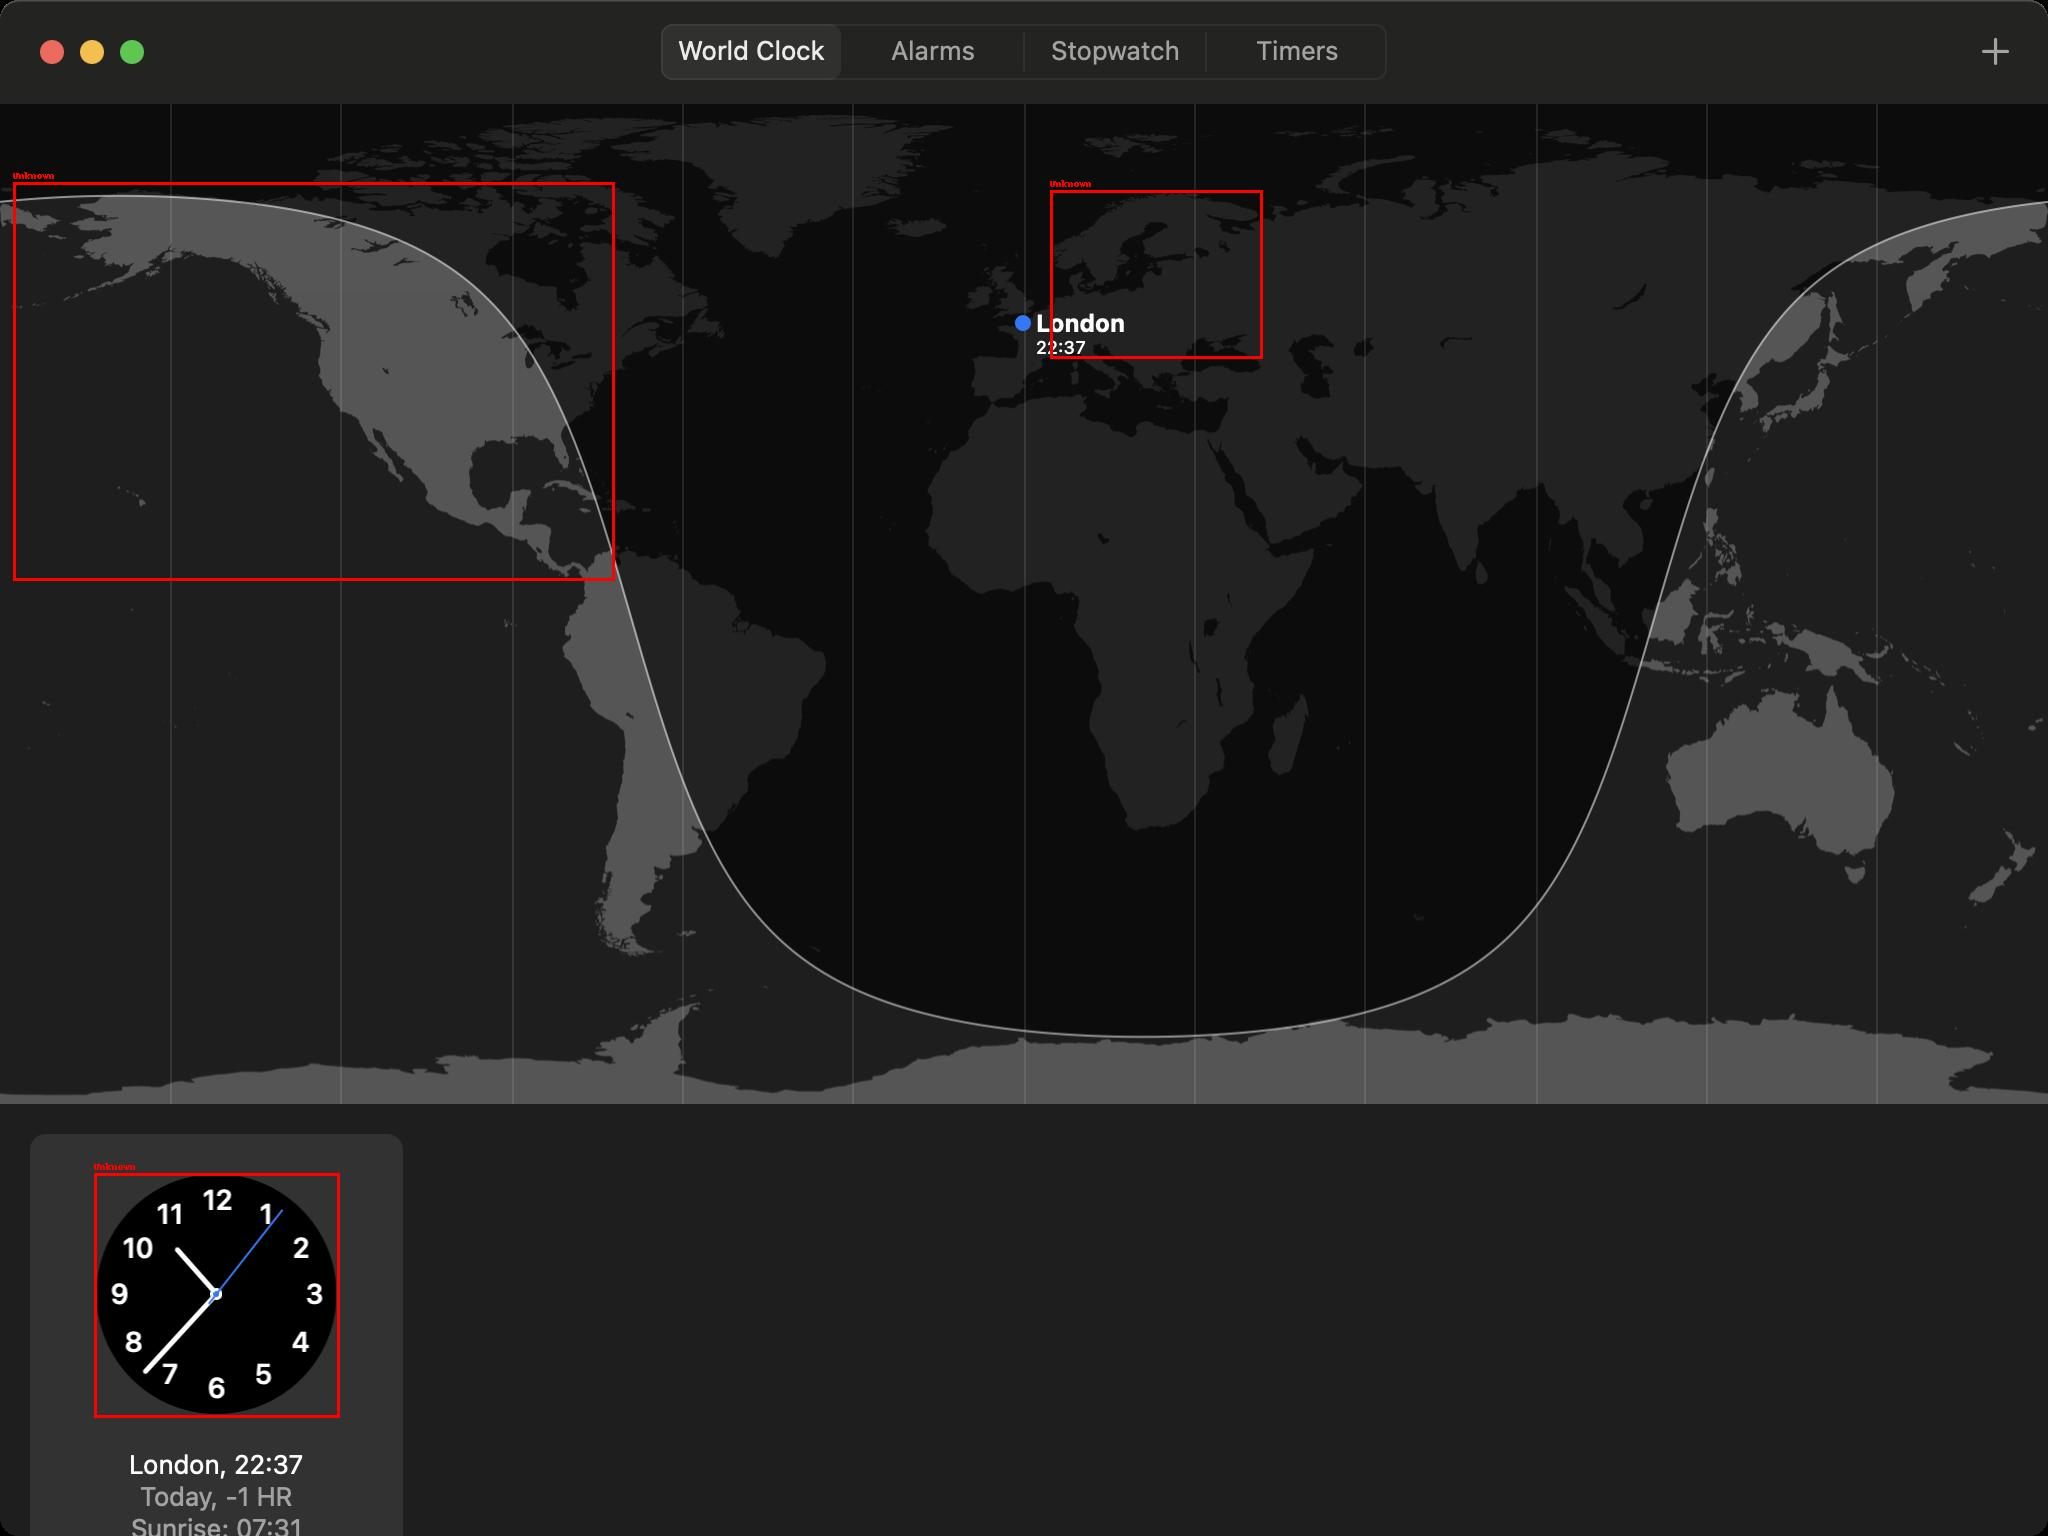

In [ ]:
import torch
import numpy as np
import json
from PIL import Image, ImageDraw
import cv2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from IPython.display import Image as ColabImage

# Constants
IMAGE_SIZE = (224, 224)
UI_CLASS_MAP_PATH = '/content/drive/MyDrive/IASA_Champ_Final/ui_class_map.json'

# Model Loading
def load_models():
    """Loads the YOLOv5 and MobileNetV2 models."""
    yolo_model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5s.pt')
    mobilenet_model = load_model('/content/drive/MyDrive/IASA_Champ_Final/mobik_net')
    return yolo_model, mobilenet_model

# Load UI class map
with open(UI_CLASS_MAP_PATH, 'r') as f:
    UI_CLASS_MAP = json.load(f)

def detect_and_classify_ui_elements(image_path, yolo_model, mobilenet_model):
    """Detects UI elements, classifies them, and draws annotations."""
    img = Image.open(image_path).convert('RGB')

    results = yolo_model(img)
    detections = results.pandas().xyxy[0]

    for index, row in detections.iterrows():
        x1, y1, x2, y2 = map(int, (row['xmin'], row['ymin'], row['xmax'], row['ymax']))

        crop_img = img.crop((x1, y1, x2, y2))
        crop_img = crop_img.resize(IMAGE_SIZE)
        crop_img_array = preprocess_input(np.array(crop_img, dtype=np.float32))
        crop_img_array = np.expand_dims(crop_img_array, axis=0)

        predictions = mobilenet_model.predict(crop_img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        class_label = UI_CLASS_MAP.get(predicted_class_index, 'Unknown')

        draw = ImageDraw.Draw(img)
        draw.rectangle(((x1, y1), (x2, y2)), outline='red', width=3)
        draw.text((x1, y1 - 12), class_label, fill='red')

    return img

def save_and_display_annotated_image(image, filename='annotated_image.jpg'):
    """Saves the annotated image and displays it using IPython.display."""
    image.save(filename)
    display(ColabImage(filename))

if __name__ == "__main__":
    image_path = '/content/drive/MyDrive/IASA_Champ_Final/IASA_Champ_Final/app_data/Clock/1707172625/Clock-1707172626.31.png'
    yolo_model, mobilenet_model = load_models()  # Load models once at the beginning

    annotated_image = detect_and_classify_ui_elements(image_path, yolo_model, mobilenet_model)
    save_and_display_annotated_image(annotated_image)


Далі мучаєм YOLO Щоб зрозуміти що не так і можливо тренити на датасеті UI елементів.

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-2-10 Python-3.10.12 torch-2.1.0+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


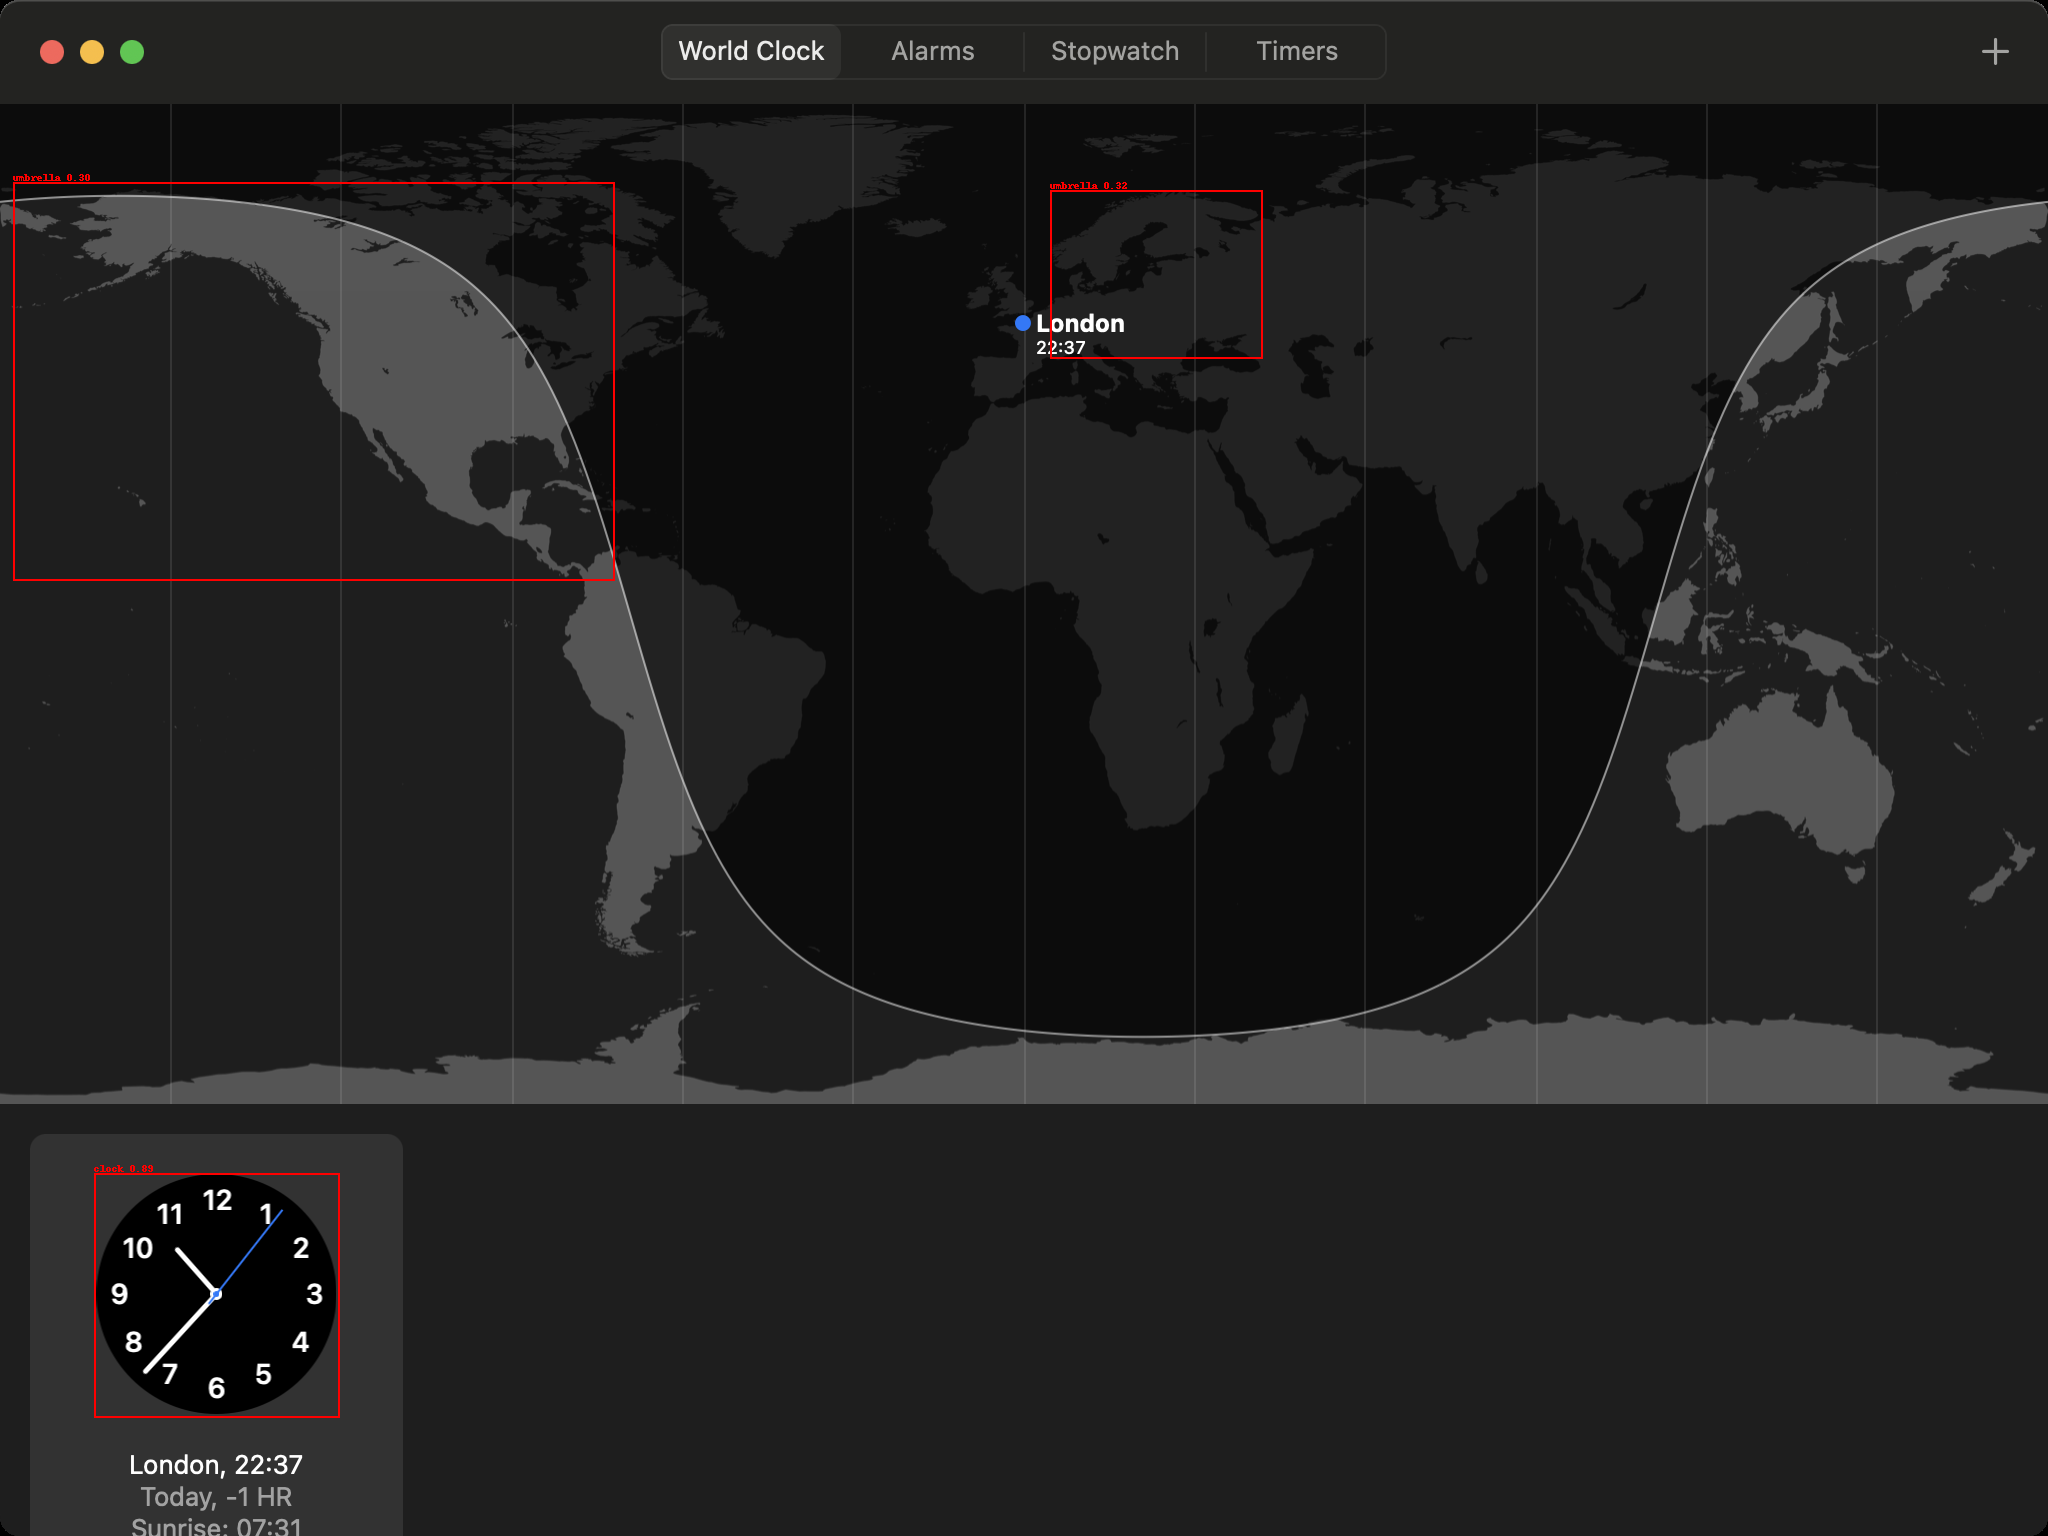

In [ ]:
import torch
from PIL import Image, ImageDraw
from IPython.display import display

# Load the YOLOv5 model
yolo_model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5s.pt')  # Replace 'path' with the actual path to your weights file

def visualize_detections(image_path, yolo_model):
    """Visualizes the detections from the YOLO model."""
    img = Image.open(image_path).convert('RGB')

    # Perform detection using YOLOv5
    results = yolo_model(img)
    detections = results.pandas().xyxy[0]  # Detections in pandas DataFrame

    # Create a draw object
    draw = ImageDraw.Draw(img)

    # Draw bounding boxes and labels on the image
    for index, row in detections.iterrows():
        # Bounding box coordinates
        x1, y1, x2, y2 = map(int, (row['xmin'], row['ymin'], row['xmax'], row['ymax']))
        # Draw the bounding box
        draw.rectangle(((x1, y1), (x2, y2)), outline='red', width=2)
        # Optionally, draw the label
        label = f"{row['name']} {row['confidence']:.2f}"
        draw.text((x1, y1 - 10), label, fill='red')

    # Display the image
    display(img)

# Path to your image
image_path = '/content/drive/MyDrive/IASA_Champ_Final/IASA_Champ_Final/app_data/Clock/1707172625/Clock-1707172626.31.png'  # Make sure to put the correct path to your image here
visualize_detections(image_path, yolo_model)


  ТУТ YOLO ідентифікує елементи інтерфейсу

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-2-10 Python-3.10.12 torch-2.1.0+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7047883 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


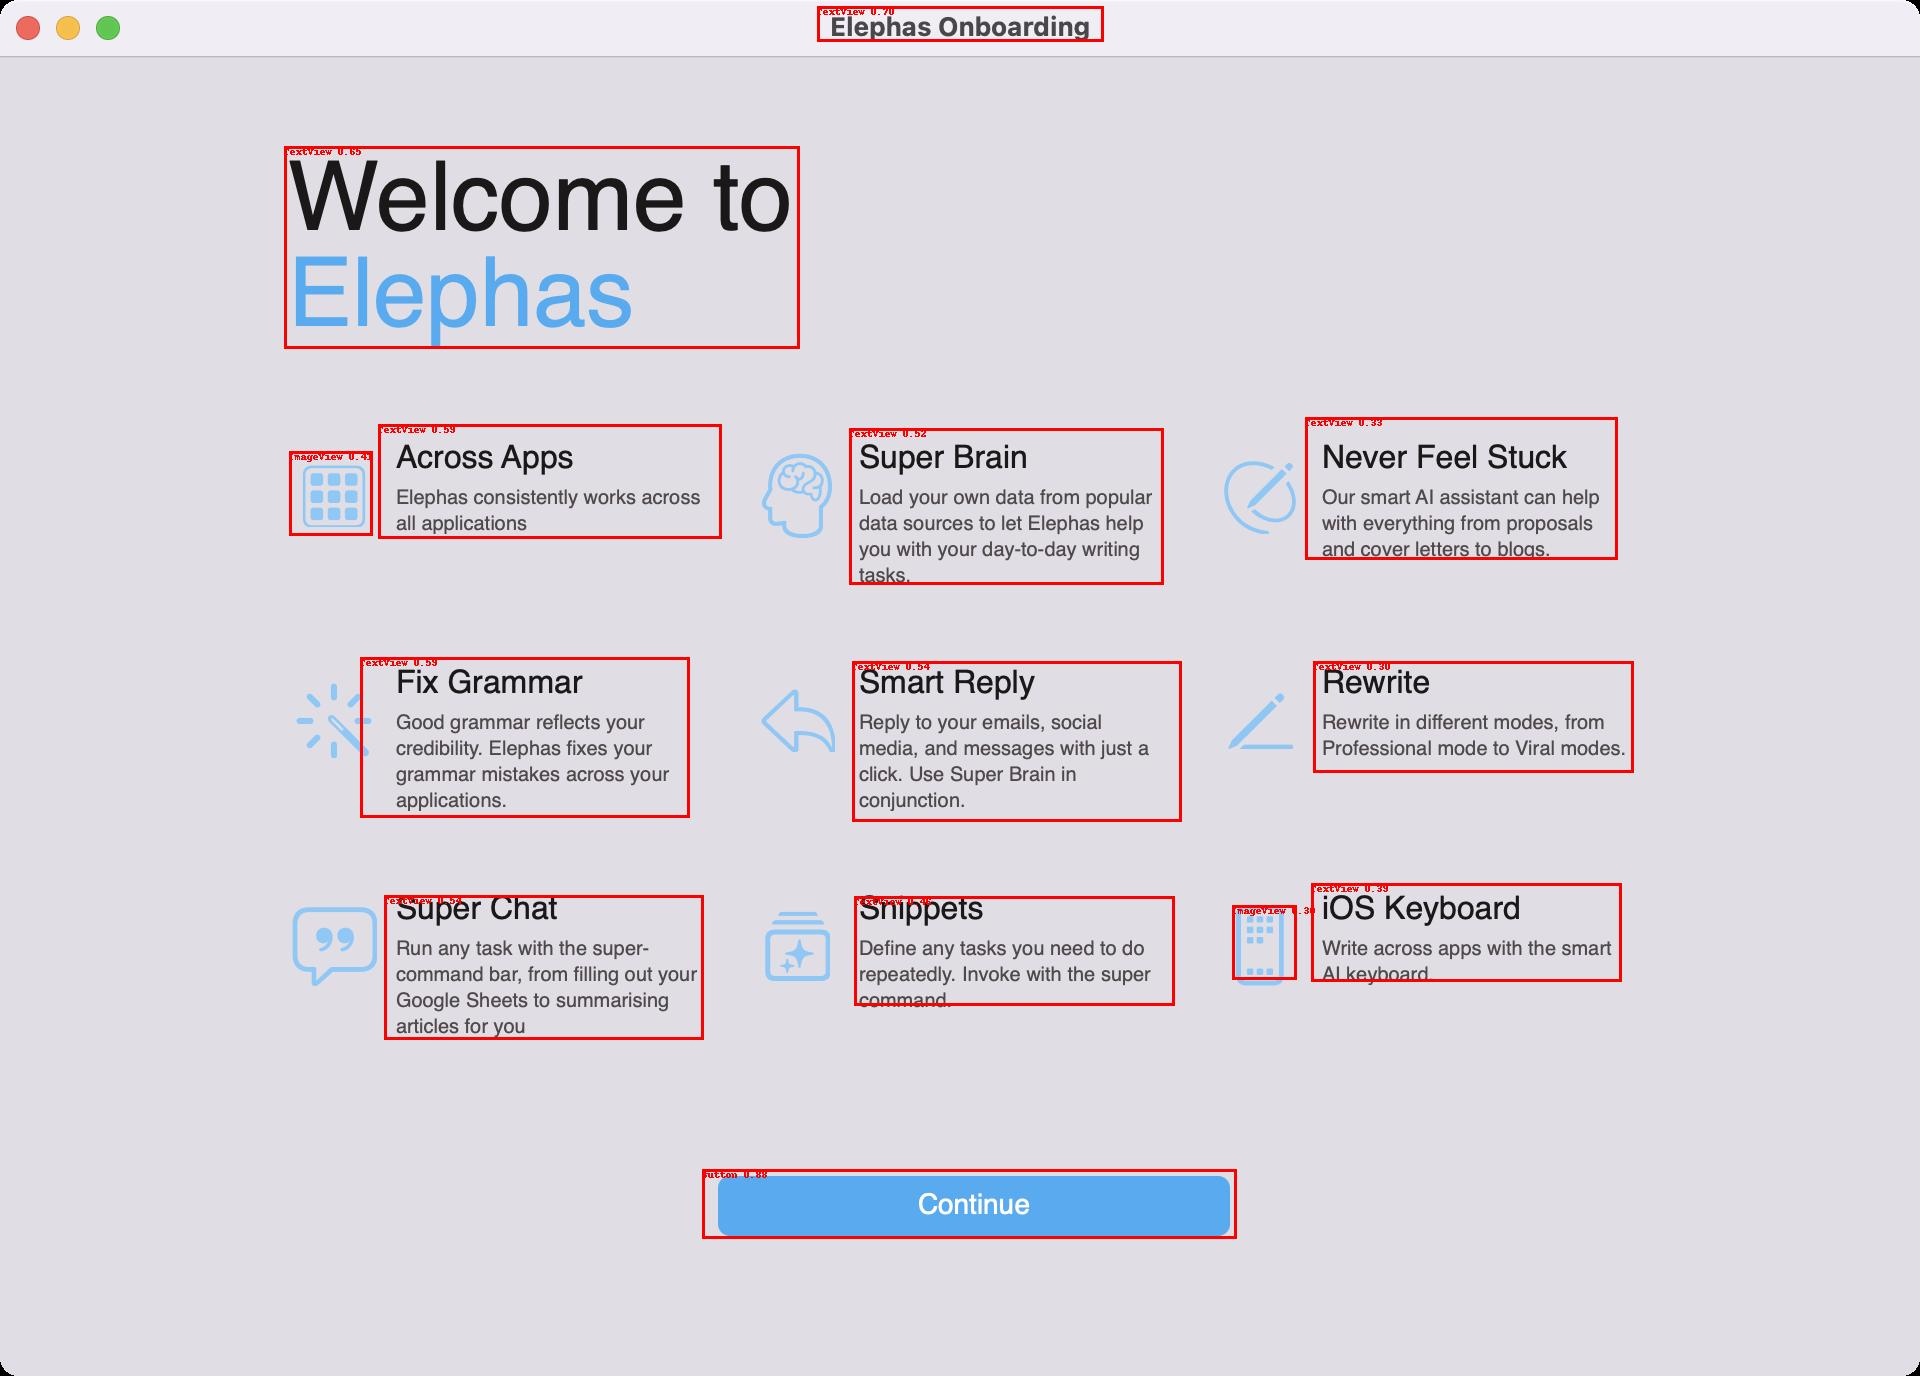

In [ ]:
import torch
from PIL import Image, ImageDraw
from IPython.display import display

# Constants
YOLO_MODEL_PATH = '/content/drive/MyDrive/best.pt'  # Adjust path as needed
IMAGE_PATH = '/content/drive/MyDrive/IASA_Champ_Final/IASA_Champ_Final/app_data/Elephas/1707210124/Elephas-1707210125.42.png'  # Adjust path as needed

# Load the trained YOLOv5 model
yolo_model = torch.hub.load('ultralytics/yolov5', 'custom', path=YOLO_MODEL_PATH)

def detect_and_annotate(image_path, model):
    # Load image
    img = Image.open(image_path).convert('RGB')

    # Perform detection
    results = model(img)

    # Draw annotations on the image
    draw = ImageDraw.Draw(img)
    for *box, conf, cls in results.xyxy[0]:
        label = f"{results.names[int(cls)]} {conf:.2f}"
        draw.rectangle(box, outline='red', width=3)
        draw.text((box[0], box[1]), label, fill='red')

    # Save and display the image
    img.save('annotated_image.jpg')
    display(Image.open('annotated_image.jpg'))

# Run detection and annotation
detect_and_annotate(IMAGE_PATH, yolo_model)


ЦЕЙ КОД ПРОХОДИТЬСЯ ПО ВСІМ ФОТКАМИ І РИСУЄ ПРЕДІКШН ПОВЕРХ

In [ ]:
import os
import json
from PIL import Image
import torch

YOLO_MODEL_PATH = '/content/drive/MyDrive/best.pt'
BASE_DIRECTORY = '/content/drive/MyDrive/IASA_Champ_Final/IASA_Champ_Final/app_data'
PROMPTS_DIRECTORY = '/content/drive/MyDrive/IASA_Champ_Final/IASA_Champ_Final/prompts'

# Load the trained YOLOv5 model
yolo_model = torch.hub.load('ultralytics/yolov5', 'custom', path=YOLO_MODEL_PATH)

def find_json_file(directory):
    """Find the JSON file in the given directory."""
    for file in os.listdir(directory):
        if file.endswith('.json'):
            return os.path.join(directory, file)
    return None

def create_text_representation_from_json(json_data, app_name):
    descriptions = [f"Description for the {app_name} application:"]

    def create_description(node, depth=0):
        name = node.get('name', 'Unnamed')
        role = node.get('role', 'element').replace('AX', '')
        position = node.get('visible_bbox', 'at an unknown position')
        state = node.get('value', 'with no specific state')
        children = node.get('children', [])

        if position != 'at an unknown position' and position is not None:
            # Ensure the position has the expected number of elements before unpacking
            if isinstance(position, list) and len(position) == 4:
                x, y, _, _ = position
                position = f"({x}, {y})"  # Format as (x, y)
            else:
                position = "Invalid position data"

        description = f"{'  ' * depth}{role} named '{name}' with state '{state}' at position {position}."
        descriptions.append(description)

        for child in children:
            create_description(child, depth + 1)

    create_description(json_data)

    return "\n".join(descriptions)

def detect_and_describe(image_path, model, app_name):
    img = Image.open(image_path).convert('RGB')
    results = model(img)

    descriptions = [f"Detected elements for the {app_name} application:"]
    for *box, conf, cls in results.xyxy[0]:
        # Extract coordinates
        x1, y1, x2, y2 = map(int, box)
        # Format the coordinates as (x, y)
        position = f"({x1}, {y1})"
        label = results.names[int(cls)]
        descriptions.append(f"{label} ({conf:.2f} confidence) at position {position}")
    return descriptions  # This return statement was missing

def process_directory(directory, model):
    for entry in os.scandir(directory):
        if entry.is_dir():
            process_directory(entry.path, model)
        elif entry.is_file() and entry.name.endswith('.png'):
            app_name = os.path.basename(os.path.dirname(directory))
            json_file_path = find_json_file(os.path.dirname(entry.path))
            text_representation = ""

            if json_file_path:  # If there's a JSON file, use it to generate the description
                with open(json_file_path, 'r') as json_file:
                    json_data = json.load(json_file)
                    text_representation = create_text_representation_from_json(json_data, app_name)
            else:  # If no JSON file is found, fallback to YOLO detection
                descriptions = detect_and_describe(entry.path, model, app_name)
                text_representation = "\n".join(descriptions)  # Convert list to string

            # Correct the prompt file name to avoid duplication
            screen_id = entry.name.split('-')[-1].split('.')[0]
            prompt_file_name = f"{app_name}_{screen_id}.txt"
            prompt_file_path = os.path.join(PROMPTS_DIRECTORY, prompt_file_name)

            with open(prompt_file_path, 'w') as text_file:
                text_file.write(text_representation)

# Make sure the prompts directory exists
os.makedirs(PROMPTS_DIRECTORY, exist_ok=True)

# Start the process
process_directory(BASE_DIRECTORY, yolo_model)



Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-2-11 Python-3.10.12 torch-2.1.0+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7047883 parameters, 0 gradients, 15.9 GFLOPs
Adding AutoShape... 


In [ ]:
!pip install openai==0.28


Формуємо запити до gpt 3.5

In [ ]:
import os
import json
import pandas as pd
import openai

# Set your OpenAI API key
openai.api_key = "INSER YOUR API KEY HERE"

# Define the directory where your screen representations are stored
SCREEN_REPRESENTATIONS_DIRECTORY = '/content/drive/MyDrive/IASA_Champ_Final/IASA_Champ_Final/prompts'

# Load the prompts from your JSON file
PROMPTS = json.load(open("/content/drive/MyDrive/IASA_Champ_Final/prompts.json"))

def get_model_response(client, question_type, question, screen_representation):
    prompt = PROMPTS[question_type]
    formatted_prompt = prompt.replace("<screen_representation>", screen_representation).replace("<question>", question)

    model_response = client.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": formatted_prompt}
        ]
    )

    # Extract the answer from the response
    answer = json.loads(model_response["choices"][0]["message"]["content"])["answer"]
    return answer


# Load the questions from your dataset
question_df = pd.read_csv("/content/drive/MyDrive/IASA_Champ_Final/IASA_Champ_Final/ui_questions_train.tsv", sep='\t')

# Iterate through the dataset
for index, row in question_df.iterrows():
    # Extract screen_id, ensure it is a string and prepend an underscore
    screen_id = str(row['Screen id'])
    question = row['Question']
    question_type = row['Answer Type'].lower()  # Convert to lowercase to match the keys in PROMPTS

    # Replace spaces and dashes with an underscore in the app name for consistency
    app_name = row['App name'].replace(' ', '_').replace('-', '_')

    # Construct the filename for the text representation
    # The filename uses an underscore before the screen_id to match your text files
    filename = f"{app_name}_{screen_id}.txt"
    filepath = os.path.join(SCREEN_REPRESENTATIONS_DIRECTORY, filename)

    # Check if the file exists
    if os.path.exists(filepath):
        # Read the screen representation from the file
        with open(filepath, 'r') as file:
            screen_representation = file.read()

        # Get the model response
        answer = get_model_response(openai, question_type, question, screen_representation)

        # Output the result - you can modify this as needed, e.g., store in a dataframe, etc.
        print(f"Question: {question} | Model Answer: {answer} | Actual Answer: {row['Answer']}")
    else:
        # Output an error message if the file doesn't exist
        print(f"Screen representation file {filename} does not exist.")

Screen representation file 24hourwallpaper_1707228345.txt does not exist.
Screen representation file 24hourwallpaper_1707228419.txt does not exist.
Screen representation file 24hourwallpaper_1707228419.txt does not exist.
Screen representation file 24hourwallpaper_1707228419.txt does not exist.
Screen representation file 24hourwallpaper_1707228389.txt does not exist.
Screen representation file 24hourwallpaper_1707228389.txt does not exist.
Screen representation file 24hourwallpaper_1707228345.txt does not exist.
Screen representation file 24hourwallpaper_1707228345.txt does not exist.
Screen representation file 24hourwallpaper_1707228389.txt does not exist.
Screen representation file Almighty_1707228267.txt does not exist.
Screen representation file Almighty_1707228277.txt does not exist.
Screen representation file Almighty_1707228194.txt does not exist.
Screen representation file Almighty_1707228277.txt does not exist.
Screen representation file Almighty_1707228277.txt does not exist.

RateLimitError: Rate limit reached for gpt-3.5-turbo in organization org-sc8dOVP50wQVeHgaLzkb8z23 on requests per min (RPM): Limit 3, Used 3, Requested 1. Please try again in 20s. Visit https://platform.openai.com/account/rate-limits to learn more. You can increase your rate limit by adding a payment method to your account at https://platform.openai.com/account/billing.